In [ ]:
!pip install python-graphblas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 24.2 MB/s eta 0:00:00


In [ ]:
import graphblas as gb
import numpy as np
from graphblas import monoid, dtypes, Matrix, binary, semiring
import networkx as nx
import matplotlib.pyplot as plt
from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread

# Наивный алгоритм

Везде считаем, что вершины графа занумерованы подряд с нуля.

 Используя python-graphblas реализовать наивный алгоритм, для матрицы смежности
A вычисляющий $ A^{3} $
 и возвращающий количество треугольников неориентированного графа.  
 * Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).  
 * Функция возвращает число --- количество треугольников в графе.

In [ ]:
def naiveA3(A):
    if not A.isequal(A.T, check_dtype=True):
        raise ValueError("Матрица должна быть симметричной и целочисленной")
    A_cub = A.mxm(A.mxm(A))
    diag = A_cub.diag()
    triangle_count = diag.reduce(gb.agg.sum).value or 0
    return int(triangle_count / 6)

In [ ]:
def naiveA3_true(A):
    return int(int(A.mxm(A.mxm(A)).diag().reduce(gb.agg.sum).value or 0) / 6)

## Проверка 1

In [ ]:
adjacency_matrix = np.array([
    [0, 1, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 1, 1],
    [0, 1, 1, 0, 0, 1],
    [1, 0, 1, 0, 0, 1],
    [0, 0, 1, 1, 1, 0]
])
A = Matrix.from_dense(adjacency_matrix, dtype=dtypes.INT64)

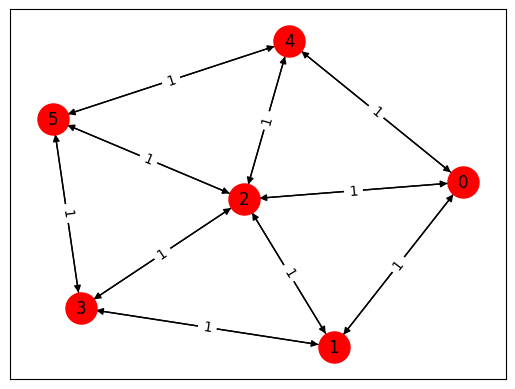

In [ ]:
#Нарисуем граф, чтобы посчитать кол-во треугольников вручную
A1 = A.dup(mask=A.dup(dtype=dtypes.BOOL))
gb.viz.draw(A1)

видно, что здесь 5 треугольников

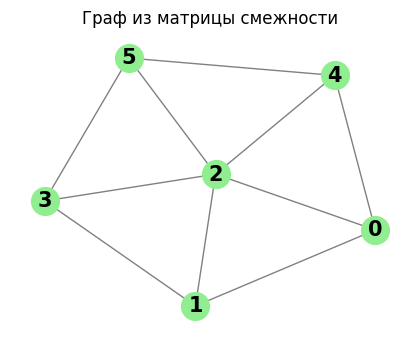

In [ ]:
#Нарисуем граф с помощью другой библиотеки
G = nx.from_numpy_array(adjacency_matrix)
plt.figure(figsize=(4, 3))
nx.draw(G, with_labels= True, node_size=400, node_color='lightgreen', font_size=15, font_weight='bold', edge_color='gray')
plt.title("Граф из матрицы смежности")
plt.show()

In [ ]:
A

"M_5"      nvals  nrows  ncols  dtype  format
gb.Matrix     36      6      6  INT64   fullr
---------------------------------------------
   0  1  2  3  4  5
0  0  1  1  0  1  0
1  1  0  1  1  0  0
2  1  1  0  1  1  1
3  0  1  1  0  0  1
4  1  0  1  0  0  1
5  0  0  1  1  1  0

In [ ]:
#Возведение в куб
A_cub = A.mxm(A.mxm(A))
A_cub

gb.MatrixExpression                          nrows  ncols  dtype
M_5.mxm(M_8, op=semiring.plus_times[INT64])      6      6  INT64

"Result"   nvals  nrows  ncols  dtype
gb.Matrix     36      6      6  INT64
-------------------------------------
   0  1   2  3  4  5
0  4  7   9  5  7  5
1  7  4   9  7  5  5
2  9  9  10  9  9  9
3  5  7   9  4  5  7
4  7  5   9  5  4  7
5  5  5   9  7  7  4

Do expr.new() or other << expr to calculate the expression.

In [ ]:
#Только диагнональные элементы
diagonal = A_cub.diag()
diagonal

"v_0"      nvals  size  dtype  format
gb.Vector      6     6  INT64    full
-------------------------------------
index  0  1   2  3  4  5
value  4  4  10  4  4  4

In [ ]:
print('Количество треугольников', naiveA3(A))
print('Количество треугольников', naiveA3_true(A))

Количество треугольников 5
Количество треугольников 5


## Проверка 2

In [ ]:
rows = [0, 1, 1, 2, 2, 0]
cols = [1, 2, 0, 0, 1, 2]
values = [1, 1, 1, 1, 1, 1]

B = gb.Matrix.from_coo(rows, cols, values, nrows=3, ncols=3, dtype=dtypes.INT64)

Количество треугольников 1


In [ ]:
B

"M_16"     nvals  nrows  ncols  dtype         format
gb.Matrix      6      3      3  INT64  bitmapr (iso)
----------------------------------------------------
   0  1  2
0     1  1
1  1     1
2  1  1

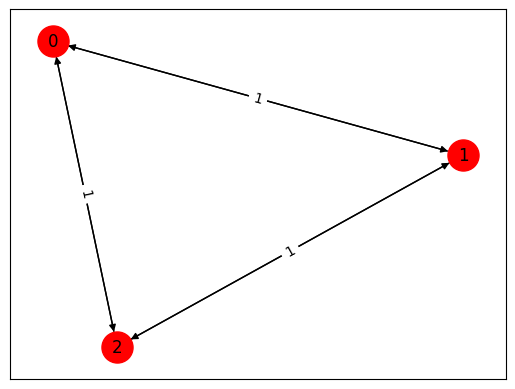

In [ ]:
gb.viz.draw(B)

In [ ]:
print('Количество треугольников', naiveA3(B))
print('Количество треугольников', naiveA3_true(B))

Количество треугольников 1
Количество треугольников 1


## Проверка 3

Несимметричная матрица

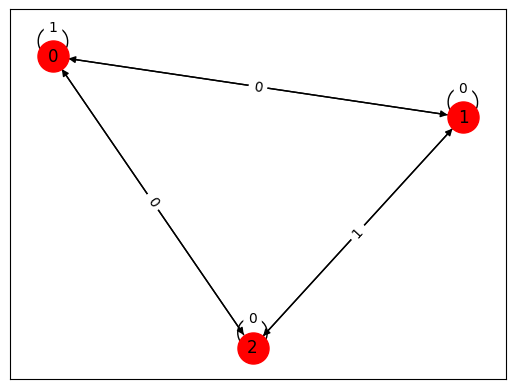

In [ ]:
adjacency_matrix_1 = np.array([
 [1, 1, 1],
 [0, 0, 1],
 [0, 1, 0]
])

C = Matrix.from_dense(adjacency_matrix_1, dtype=dtypes.INT64)
gb.viz.draw(C)

In [ ]:
print('Количество треугольников', naiveA3(C))

ValueError: Матрица должна быть симметричной и целочисленной

# Наивный алгоритм с маской

 Используя python-graphblas реализовать наивный алгоритм с маской, для матрицы смежности A вычисляющий $ A^{2} $
 и возвращающий количество треугольников неориентированного графа.  
 * Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).  
 * Функция возвращает число --- количество треугольников в графе.

In [ ]:
import graphblas as gb
from graphblas import monoid, binary, semiring

In [ ]:
def NaiveA2(A):
    if not A.isequal(A.T, check_dtype=True):
        raise ValueError("Матрица должна быть симметричной и целочисленной")

    A2=A.mxm(A)
    triA = A2.dup(mask=A.dup(dtype=dtypes.BOOL))
    cnt_triangle=(triA.reduce_scalar(gb.monoid.plus).value or 0)

    return int(cnt_triangle/6)


## Проверка 1

In [ ]:
adjacency_matrix = np.array([
    [0, 1, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 1, 1],
    [0, 1, 1, 0, 0, 1],
    [1, 0, 1, 0, 0, 1],
    [0, 0, 1, 1, 1, 0]
])

A = Matrix.from_dense(adjacency_matrix, dtype=dtypes.INT64)

In [ ]:
#Макса для вычислений
A.dup(dtype=dtypes.BOOL)

"M_51"     nvals  nrows  ncols  dtype  format
gb.Matrix     36      6      6   BOOL   fullr
---------------------------------------------
       0      1      2      3      4      5
0  False   True   True  False   True  False
1   True  False   True   True  False  False
2   True   True  False   True   True   True
3  False   True   True  False  False   True
4   True  False   True  False  False   True
5  False  False   True   True   True  False

In [ ]:
#Результат вычислений после маски
A2=A.mxm(A) #возводим в квадрат матрицу смежности
triA=A2.dup(mask=A.dup(dtype=dtypes.BOOL))
triA

"M_53"     nvals  nrows  ncols  dtype   format
gb.Matrix     20      6      6  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5
0     1  2     1   
1  1     2  1      
2  2  2     2  2  2
3     1  2        1
4  1     2        1
5        2  1  1

In [ ]:
print('Количество треугольников', NaiveA2(A))

Количество треугольников 5


## Проверка 2

In [ ]:
rows = [0, 1, 1, 2, 2, 0]
cols = [1, 2, 0, 0, 1, 2]
values = [1, 1, 1, 1, 1, 1]

B = gb.Matrix.from_coo(rows, cols, values, nrows=3, ncols=3, dtype=dtypes.INT64)

In [ ]:
print('Количество треугольников', NaiveA2(B))

Количество треугольников 1


## Проверка 3

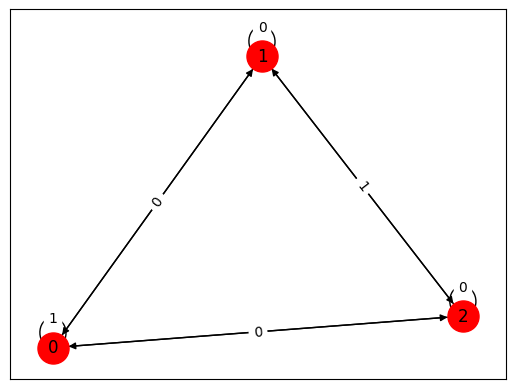

In [ ]:
adjacency_matrix_1 = np.array([
 [1, 1, 1],
 [0, 0, 1],
 [0, 1, 0]
])

C = Matrix.from_dense(adjacency_matrix_1, dtype=dtypes.INT64)
gb.viz.draw(C)

In [ ]:
print('Количество треугольников', NaiveA2(C))

ValueError: Матрица должна быть симметричной и целочисленной

# Сohen's algorithm

 Используя python-graphblas реализовать Сohen's algorithm, вычисляющий количество треугольников неориентированного графа.  
 * Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).  
 * Функция возвращает число --- количество треугольников в графе.

In [ ]:
import graphblas as gb
from graphblas import monoid, binary, semiring, Matrix, dtypes

def cohen(A):
    if not A.isequal(A.T, check_dtype=True):
        raise ValueError("Матрица должна быть симметричной и целочисленной")
    low_tr = gb.select.tril(A) # ниж треугольник
    upp_tr = gb.select.triu(A) #верх треугольник

    tr = low_tr.mxm(upp_tr) #Умножение ниж * верх
    mask_tr = tr.dup(mask=A.dup(dtype=dtypes.BOOL)) # Маска
    triangle_count = mask_tr.reduce_scalar(gb.monoid.plus).value or 0 #Подсчет элементов
    return int(triangle_count / 2)

## Проверка 1

In [ ]:
adjacency_matrix = np.array([
    [0, 1, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 1, 1],
    [0, 1, 1, 0, 0, 1],
    [1, 0, 1, 0, 0, 1],
    [0, 0, 1, 1, 1, 0]
])

A = Matrix.from_dense(adjacency_matrix, dtype=dtypes.INT64)

In [ ]:
#Нижний треугольник матрицы
gb.select.tril(A)

gb.MatrixExpression                           nrows  ncols  dtype
M_159.select(select.tril[BOOL], thunk=False)      6      6  INT64

"Result"   nvals  nrows  ncols  dtype
gb.Matrix     21      6      6  INT64
-------------------------------------
   0  1  2  3  4  5
0  0               
1  1  0            
2  1  1  0         
3  0  1  1  0      
4  1  0  1  0  0   
5  0  0  1  1  1  0

Do expr.new() or other << expr to calculate the expression.

In [ ]:
#Верхний треугольник матрицы
gb.select.triu(A)

gb.MatrixExpression                           nrows  ncols  dtype
M_159.select(select.triu[BOOL], thunk=False)      6      6  INT64

"Result"   nvals  nrows  ncols  dtype
gb.Matrix     21      6      6  INT64
-------------------------------------
   0  1  2  3  4  5
0  0  1  1  0  1  0
1     0  1  1  0  0
2        0  1  1  1
3           0  0  1
4              0  1
5                 0

Do expr.new() or other << expr to calculate the expression.

In [ ]:
# Перемножаем нижний и верхний треугольники
gb.select.tril(A).mxm(gb.select.triu(A))

gb.MatrixExpression                              nrows  ncols  dtype
M_164.mxm(M_165, op=semiring.plus_times[INT64])      6      6  INT64

"Result"   nvals  nrows  ncols  dtype
gb.Matrix     36      6      6  INT64
-------------------------------------
   0  1  2  3  4  5
0  0  0  0  0  0  0
1  0  1  1  0  1  0
2  0  1  2  1  1  0
3  0  0  1  2  1  1
4  0  1  1  1  2  1
5  0  0  0  1  1  3

Do expr.new() or other << expr to calculate the expression.

In [ ]:
#Используем маску
gb.select.tril(A).mxm(gb.select.triu(A)).dup(mask=A.dup(dtype=dtypes.BOOL))

"M_183"    nvals  nrows  ncols  dtype   format
gb.Matrix     20      6      6  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5
0     0  0     0   
1  0     1  0      
2  0  1     1  1  0
3     0  1        1
4  0     1        1
5        0  1  1

In [ ]:
#Суммируем все значения и делим на 2
gb.select.tril(A).mxm(gb.select.triu(A)).dup(mask=A.dup(dtype=dtypes.BOOL)).reduce_scalar(gb.monoid.plus).value / 2 or 0

5.0

In [ ]:
print('Количество треугольников', cohen(A))

Количество треугольников 5


## Проверка 2

In [ ]:
rows = [0, 1, 1, 2, 2, 0]
cols = [1, 2, 0, 0, 1, 2]
values = [1, 1, 1, 1, 1, 1]

B = gb.Matrix.from_coo(rows, cols, values, nrows=3, ncols=3, dtype=dtypes.INT64)
print('Количество треугольников', cohen(B))

Количество треугольников 1


## Проверка 3

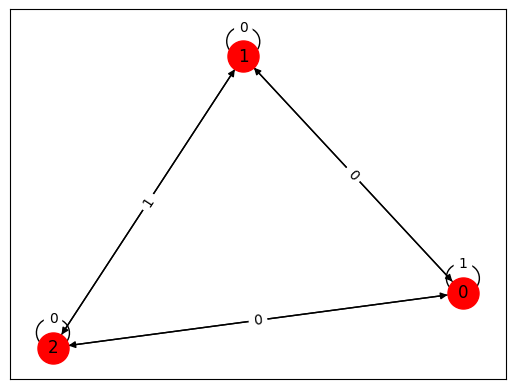

ValueError: Матрица должна быть симметричной и целочисленной

In [ ]:
adjacency_matrix_1 = np.array([
 [1, 1, 1],
 [0, 0, 1],
 [0, 1, 0]
])

C = Matrix.from_dense(adjacency_matrix_1, dtype=dtypes.INT64)
gb.viz.draw(C)
print('Количество треугольников', cohen(С))

# Sandia algorithm

 Используя python-graphblas реализовать Sandia algorithm, вычисляющий количество треугольников неориентированного графа.  
 * Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).  
 * Функция возвращает число --- количество треугольников в графе.  

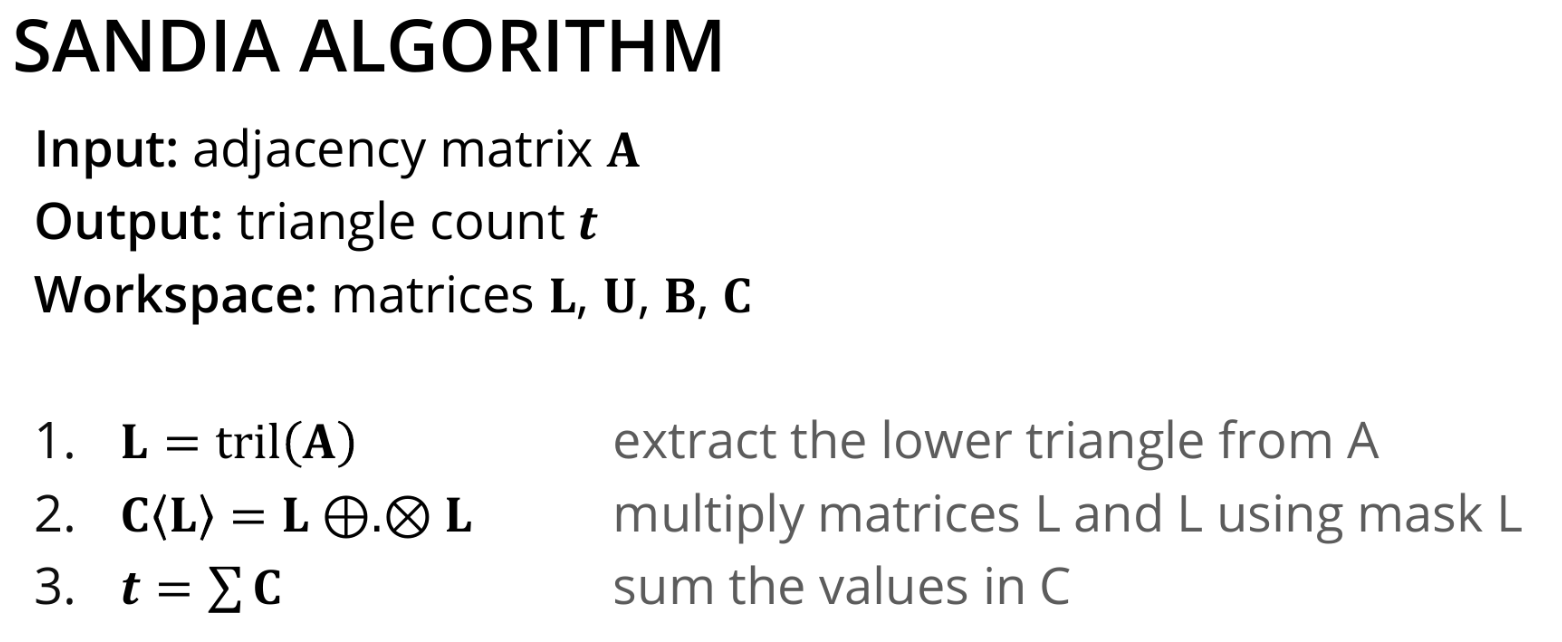

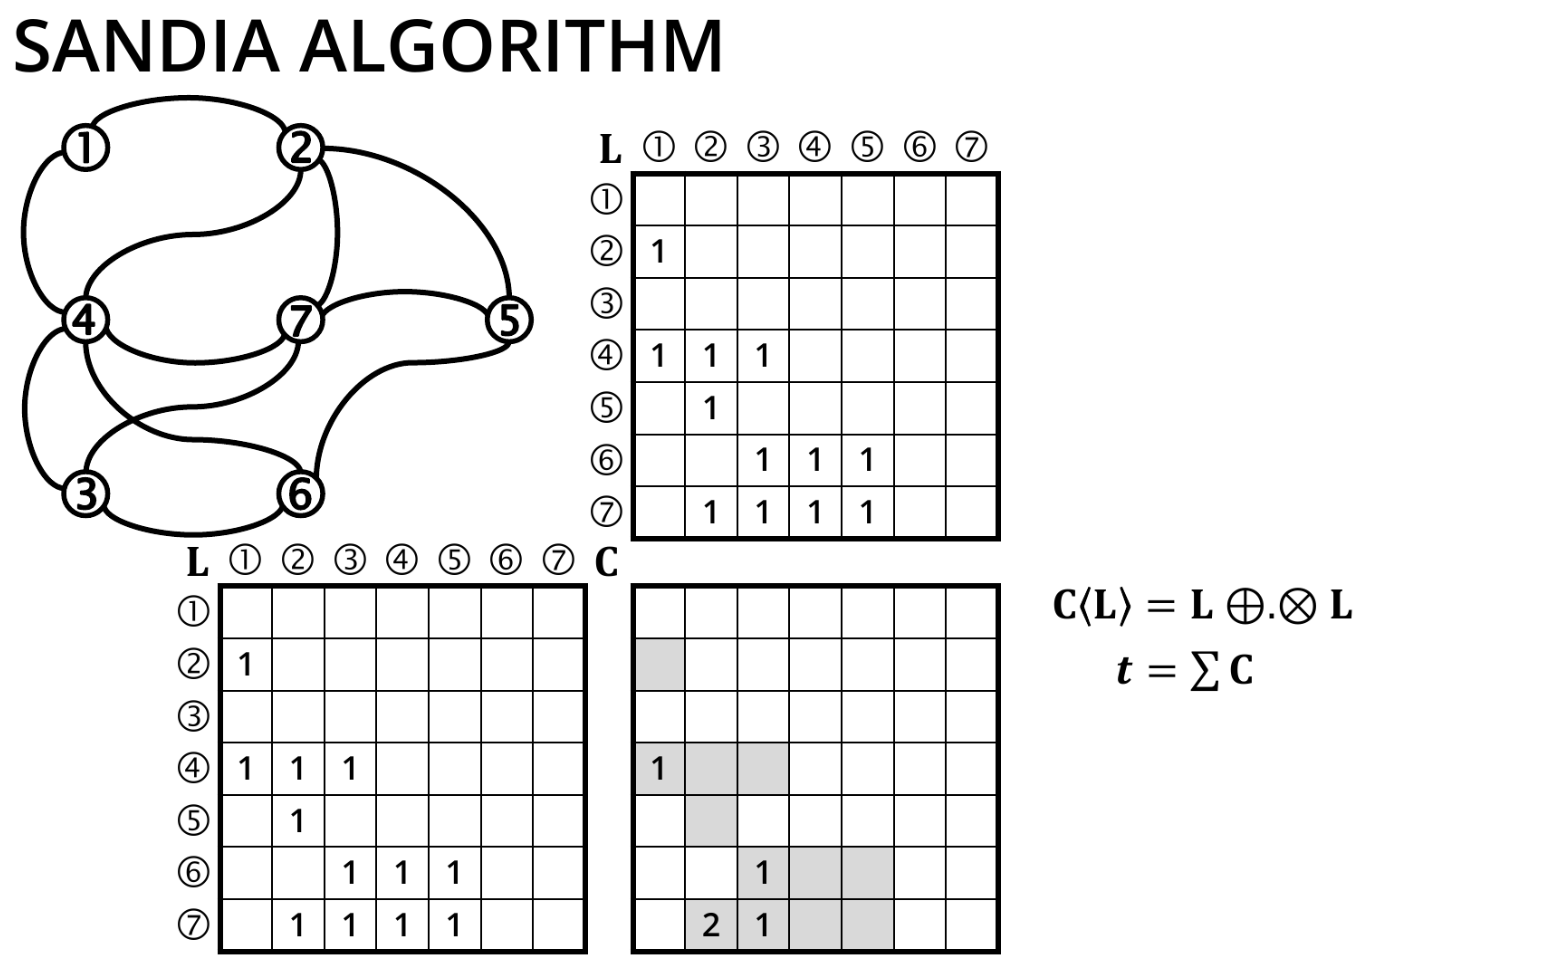

In [ ]:
def sandia(A):
  low_tr = gb.select.tril(A)
  low_tr_2 = low_tr.mxm(low_tr)
  low_tr_mask = low_tr_2.dup(mask=A.dup(dtype=dtypes.BOOL))
  return low_tr_mask.reduce_scalar(gb.monoid.plus).value

## Проверка 1

In [ ]:
adjacency_matrix = np.array([
    [0, 1, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 1, 1],
    [0, 1, 1, 0, 0, 1],
    [1, 0, 1, 0, 0, 1],
    [0, 0, 1, 1, 1, 0]
])

A = Matrix.from_dense(adjacency_matrix, dtype=dtypes.INT64)

In [ ]:
#Нижний треугольник матрицы
gb.select.tril(A)

gb.MatrixExpression                           nrows  ncols  dtype
M_196.select(select.tril[BOOL], thunk=False)      6      6  INT64

"Result"   nvals  nrows  ncols  dtype
gb.Matrix     21      6      6  INT64
-------------------------------------
   0  1  2  3  4  5
0  0               
1  1  0            
2  1  1  0         
3  0  1  1  0      
4  1  0  1  0  0   
5  0  0  1  1  1  0

Do expr.new() or other << expr to calculate the expression.

In [ ]:
gb.select.tril(A).mxm(gb.select.tril(A)).dup(mask=A.dup(dtype=dtypes.BOOL)).reduce_scalar(gb.monoid.plus).value

5

In [ ]:
print('Количество треугольников', sandia(A))

Количество треугольников 5


## Проверка 2

In [ ]:
rows = [0, 1, 1, 2, 2, 0]
cols = [1, 2, 0, 0, 1, 2]
values = [1, 1, 1, 1, 1, 1]

B = gb.Matrix.from_coo(rows, cols, values, nrows=3, ncols=3, dtype=dtypes.INT64)
print('Количество треугольников', sandia(B))

Количество треугольников 1


## Проверка 3

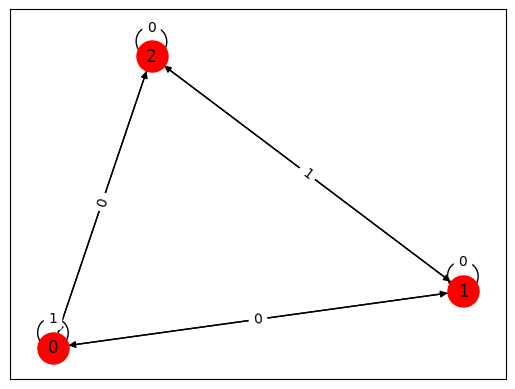

ValueError: Матрица должна быть симметричной и целочисленной

In [ ]:
adjacency_matrix_1 = np.array([
 [1, 1, 1],
 [0, 0, 1],
 [0, 1, 0]
])

C = Matrix.from_dense(adjacency_matrix_1, dtype=dtypes.INT64)
gb.viz.draw(C)
print('Количество треугольников', cohen(С))

# Функция вычисляющую кол-во треугольников по вершине

Используя python-graphblas реализовать функцию, вычисляющую для каждой вершины неориентированного графа количество треугольников, в которых она участвует.  
 * Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).  
 * Функция возвращает массив, где для каждой вершины указано, в скольки треугольниках она участвует.  

 Добавить тесты для проверки корректности полученных реализаций.

In [ ]:
import graphblas as gb
from graphblas import dtypes

def count_triangles_of_vertex(A):
    # Проверка, что матрица A симметричная и отражает неориентированный граф
    if not A.isequal(A.T, check_dtype=True):
        raise ValueError("Матрица должна быть симметричной и целочисленной")

    A_cub = A.mxm(A.mxm(A)) #Возводим в куб
    diagonal = A_cub.diag() #Берем диагональ
    diagonal << diagonal.apply(gb.binary.truediv, right=2) #Делим на 2 и переназначаем диагональ
    triangle_counts = diagonal.to_dense() #выводим в numpy
    return triangle_counts.tolist()

In [ ]:
A_cub = A.mxm(A.mxm(A))
A_cub

gb.MatrixExpression                              nrows  ncols  dtype
M_109.mxm(M_120, op=semiring.plus_times[INT64])      6      6  INT64

"Result"   nvals  nrows  ncols  dtype
gb.Matrix     36      6      6  INT64
-------------------------------------
   0  1   2  3  4  5
0  4  7   9  5  7  5
1  7  4   9  7  5  5
2  9  9  10  9  9  9
3  5  7   9  4  5  7
4  7  5   9  5  4  7
5  5  5   9  7  7  4

Do expr.new() or other << expr to calculate the expression.

In [ ]:
diagonal = A_cub.diag()
diagonal

"v_30"     nvals  size  dtype  format
gb.Vector      6     6  INT64    full
-------------------------------------
index  0  1   2  3  4  5
value  4  4  10  4  4  4

In [ ]:
diagonal << diagonal.apply(gb.binary.truediv, right=2)
diagonal

"v_30"     nvals  size  dtype  format
gb.Vector      6     6  INT64    full
-------------------------------------
index  0  1  2  3  4  5
value  2  2  5  2  2  2

In [ ]:
diagonal.to_dense()

array([2, 2, 5, 2, 2, 2])

In [ ]:
triangle_counts = diagonal.to_dense()
triangle_counts

array([2, 2, 5, 2, 2, 2])

In [ ]:
triangle_counts = diagonal.to_dense()
triangle_counts

array([2, 2, 5, 2, 2, 2])

## Проверка 1

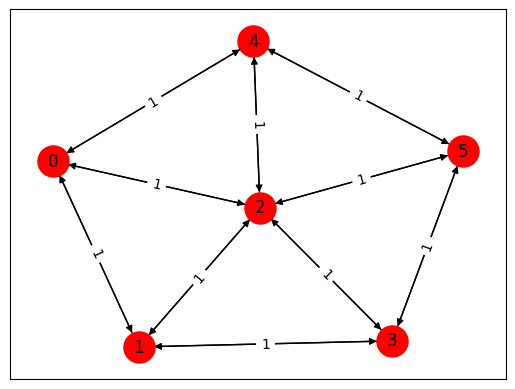

In [ ]:
adjacency_matrix = np.array([
    [0, 1, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 1, 1],
    [0, 1, 1, 0, 0, 1],
    [1, 0, 1, 0, 0, 1],
    [0, 0, 1, 1, 1, 0]
])

A = Matrix.from_dense(adjacency_matrix, dtype=dtypes.INT64)
gb.viz.draw(A.dup(mask=A.dup(dtype=dtypes.BOOL)))

In [ ]:
count_triangles_of_vertex(A)


[2, 2, 5, 2, 2, 2]

## Проверка 2

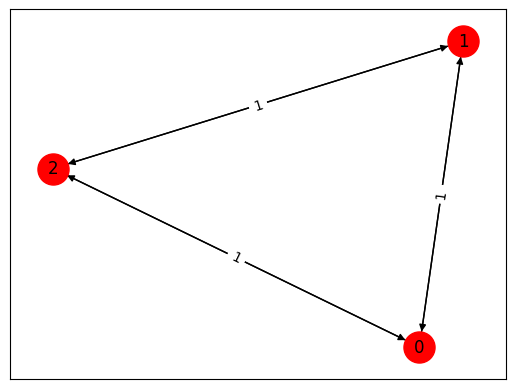

In [ ]:
rows = [0, 1, 1, 2, 2, 0]
cols = [1, 2, 0, 0, 1, 2]
values = [1, 1, 1, 1, 1, 1]

B = gb.Matrix.from_coo(rows, cols, values, nrows=3, ncols=3, dtype=dtypes.INT64)
gb.viz.draw(B)

In [ ]:
count_triangles_of_vertex(B)

[1, 1, 1]

## Проверка 3

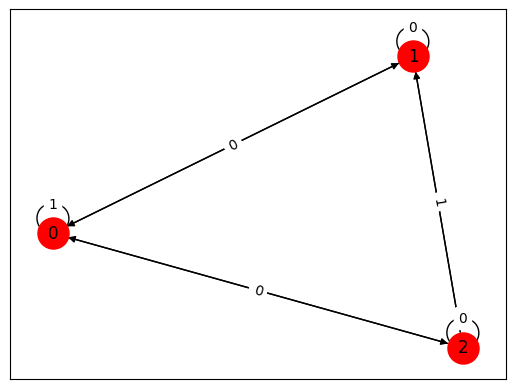

In [ ]:
adjacency_matrix_1 = np.array([
 [1, 1, 1],
 [0, 0, 1],
 [0, 1, 0]
])

C = Matrix.from_dense(adjacency_matrix_1, dtype=dtypes.INT64)
gb.viz.draw(C)

In [ ]:
count_triangles_of_vertex(C)

ValueError: Матрица должна быть симметричной и целочисленной

## Проверка 4

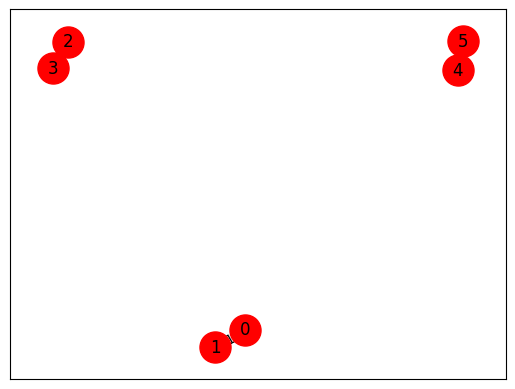

[0, 0, 0, 0, 0, 0]

In [ ]:
DD = np.array([
    [0, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0]
], dtype=int)

D = Matrix.from_dense(DD, dtype=dtypes.INT64)
gb.viz.draw(D.dup(mask=D.dup(dtype=dtypes.BOOL)))
count_triangles_of_vertex(D)

# Задание на оценку времени


(+1 балл) Скачать 10 графов в формате Matrix Market с сайта SuiteSparse Matrix Collection и оценить время работы всех полученных реализаций.  
Сделать выводы.  

 В качестве фильтров для поиска графов на сайте использовать следующие значения: Rutherford-Boeing Type = Binary, Special Structure = Symmetric, Nonzeros.Min = 10000.

In [ ]:
from graphblas.io import mmread

In [ ]:
def time(A):
    result = [naiveA3(A), NaiveA2(A), cohen(A), sandia(A)]
    print(result)
    if not all(i == i for i in result):
       print("Не все возвращаемые значения равны")
    else:
        %timeit naiveA3(A)
        %timeit NaiveA2(A)
        %timeit cohen(A)
        %timeit sandia(A)
        #%timeit count_vertex_triangles(A)

## Тест 1

In [ ]:
M1 = mmread('/content/email.mtx')
M1

"M_118806"  nvals  nrows  ncols  dtype     format
gb.Matrix   10902   1133   1133   FP64  csr (iso)
-------------------------------------------------
     0    1    2    3    4    5    6    7    8    9     ... 1123 1124 1125  \
0          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...                  
1     1.0       1.0  1.0       1.0  1.0  1.0  1.0  1.0  ...                  
2     1.0  1.0       1.0       1.0  1.0  1.0  1.0       ...                  
3     1.0  1.0  1.0                                     ...                  
4     1.0                      1.0                      ...                  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1128                                                    ...                  
1129                                                    ...                  
1130                                                    ...                  
1131                                                    ...                  
1132                                                    ...                  

     1126 1127 1128 1129 1130 1131 1132  
0                                        
1                                        
2                                        
3                                        
4                                        
...   ...  ...  ...  ...  ...  ...  ...  
1128                                     
1129                                     
1130                                     
1131                                     
1132

### Результат

In [ ]:
time(M1)

[5343, 5343, 5343, 5343.0]
34.8 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.8 ms ± 69.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.63 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
972 µs ± 149 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Тест 2

In [ ]:
M2 = mmread('/content/G5.mtx')
M2

"M_74784"  nvals  nrows  ncols  dtype     format
gb.Matrix  38352    800    800   FP64  csr (iso)
------------------------------------------------
    0   1   2   3   4   5    6    7   8   9    ...  790  791  792 793 794  \
0                                              ...       1.0                
1                            1.0               ...                          
2                                              ...                          
3                                              ...                          
4                                              ...                          
..   ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ...  ...  ...  ...  ..  ..   
795                                            ...            1.0           
796                                            ...                          
797                                            ...  1.0                     
798                                            ...            1.0           
799                               1.0          ...                          

     795 796  797 798  799  
0                           
1                           
2                           
3                           
4                           
..   ...  ..  ...  ..  ...  
795           1.0           
796                         
797  1.0               1.0  
798                         
799           1.0

### Результат

In [ ]:
time(M2)

[18262, 18262, 18262, 18262.0]
268 ms ± 63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.84 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.69 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.14 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Тест 3

In [ ]:
M3 = mmread('/content/G63.mtx')
M3

"M_82111"  nvals  nrows  ncols  dtype     format
gb.Matrix  82918   7000   7000   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9     ... 6990 6991 6992  \
0          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0       ...                  
1     1.0       1.0  1.0  1.0  1.0  1.0  1.0       1.0  ...                  
2     1.0  1.0       1.0                 1.0            ...                  
3     1.0  1.0  1.0       1.0  1.0  1.0  1.0  1.0  1.0  ...                  
4     1.0  1.0       1.0       1.0  1.0  1.0  1.0  1.0  ...                  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
6995                                                    ...                  
6996                                                    ...                  
6997                      1.0                           ...                  
6998                                                    ...                  
6999                                                    ...                  

     6993 6994 6995 6996 6997 6998 6999  
0                                        
1                                        
2                                        
3                                        
4                         1.0            
...   ...  ...  ...  ...  ...  ...  ...  
6995                                     
6996                                     
6997                                     
6998                                     
6999

### Результат

In [ ]:
time(M3)

[42546, 42546, 42546, 42546.0]
2.91 s ± 869 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
33.7 ms ± 9.61 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
37.9 ms ± 9.79 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 4.93 times longer than the fastest. This could mean that an intermediate result is being cached.
32.1 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Тест 4

In [ ]:
M4 = mmread('/content/G2.mtx')
M4

"M_1"      nvals  nrows  ncols  dtype     format
gb.Matrix  38352    800    800   FP64  csr (iso)
------------------------------------------------
    0    1   2   3   4    5   6    7   8    9    ... 790  791  792  793  794  \
0                                  1.0      1.0  ...                     1.0   
1                                                ...      1.0                  
2                         1.0                    ...                           
3                                                ...           1.0             
4                                                ...      1.0                  
..   ..  ...  ..  ..  ..  ...  ..  ...  ..  ...  ...  ..  ...  ...  ...  ...   
795                                1.0           ...                1.0        
796                                              ...                1.0        
797                                              ...                           
798                                              ...                1.0        
799      1.0                                     ...                           

    795 796 797 798  799  
0                         
1                    1.0  
2                         
3                         
4                         
..   ..  ..  ..  ..  ...  
795                       
796                       
797                       
798                       
799

### Результат

In [ ]:
time(M4)

[18194, 18194, 18194, 18194.0]
190 ms ± 61.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.26 ms ± 95.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.64 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.44 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Тест 5

In [ ]:
M5 = mmread('/content/dwt_2680.mtx')
M5

"M_13341"  nvals  nrows  ncols  dtype     format
gb.Matrix  25026   2680   2680   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9     ... 2670 2671 2672  \
0     1.0  1.0            1.0                      1.0  ...                  
1     1.0  1.0            1.0                      1.0  ...                  
2               1.0  1.0                      1.0       ...                  
3               1.0  1.0                      1.0       ...                  
4     1.0  1.0            1.0  1.0                 1.0  ...                  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2675                                                    ...  1.0  1.0        
2676                                                    ...            1.0   
2677                                                    ...            1.0   
2678                                                    ...                  
2679                                                    ...                  

     2673 2674 2675 2676 2677 2678 2679  
0                                        
1                                        
2                                        
3                                        
4                                        
...   ...  ...  ...  ...  ...  ...  ...  
2675       1.0  1.0            1.0  1.0  
2676  1.0            1.0  1.0            
2677  1.0  1.0       1.0  1.0  1.0       
2678  1.0  1.0  1.0       1.0  1.0  1.0  
2679       1.0  1.0            1.0  1.0

### Результат

In [ ]:
time(M5)

[23369, 23369, 29849, 36776.0]
14.2 ms ± 5.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.44 ms ± 931 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.41 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.26 ms ± 65.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Тест 6

In [ ]:
M6 = mmread('/content/power.mtx')
M6

"M_177379"  nvals  nrows  ncols  dtype     format
gb.Matrix   13188   4941   4941   FP64  csr (iso)
-------------------------------------------------
     0    1    2    3    4    5    6    7    8    9     ... 4931 4932 4933  \
0                                                       ...                  
1                                                       ...                  
2                                                       ...                  
3                                                       ...                  
4                                                       ...                  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4936                                                    ...                  
4937                                                    ...                  
4938                                                    ...                  
4939                                                    ...            1.0   
4940                                                    ...                  

     4934 4935 4936 4937 4938 4939 4940  
0                                        
1                                        
2                                        
3                                        
4                                        
...   ...  ...  ...  ...  ...  ...  ...  
4936                      1.0            
4937       1.0                           
4938            1.0                      
4939                                1.0  
4940                           1.0

### Результат

In [ ]:
time(M6)

[651, 651, 651, 651.0]
14.6 ms ± 5.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.63 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.83 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.2 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Тест 7

In [ ]:
M7 = mmread('/content/crack.mtx')
M7

"M_235952"  nvals  nrows  ncols  dtype     format
gb.Matrix   60760  10240  10240   FP64  csr (iso)
-------------------------------------------------
      0     1     2     3     4     5     6     7     8     9      ... 10230  \
0                                                                  ...         
1                                                                  ...         
2                                                                  ...         
3                                                                  ...         
4                                                                  ...         
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
10235                                                              ...         
10236                                                              ...         
10237                                                              ...         
10238                                                              ...         
10239                                                              ...         

      10231 10232 10233 10234 10235 10236 10237 10238 10239  
0                                                            
1                                                            
2                                                            
3                                                            
4                                                            
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
10235   1.0               1.0                                
10236                                       1.0   1.0   1.0  
10237                     1.0         1.0                    
10238                                 1.0                    
10239                                 1.0

### Результат

In [ ]:
time(M7)

[20141, 20141, 20141, 20141.0]
The slowest run took 4.87 times longer than the fastest. This could mean that an intermediate result is being cached.
72.2 ms ± 47.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.72 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.86 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.44 ms ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Тест 8

In [ ]:
M8 = mmread('/content/rgg_n_2_15_s0.mtx')
M8

"M_261706"   nvals  nrows  ncols  dtype     format
gb.Matrix   320480  32768  32768   FP64  csr (iso)
--------------------------------------------------
     row  col  val
0      0   11  1.0
1      0   12  1.0
2      0   25  1.0
3      0   35  1.0
4      0   42  1.0
5      0   53  1.0
6      0   62  1.0
7      0   71  1.0
8      1    5  1.0
9      1    8  1.0
...  ...  ...  ...

### Результат

In [ ]:
time(M8)

[307546, 307546, 307546, 307546.0]
239 ms ± 60.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
95.1 ms ± 35.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.7 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.8 ms ± 9.54 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Тест 9

In [ ]:
M9 = mmread('/content/vsp_barth5_1Ksep_50in_5Kout.mtx')
M9

"M_264653"   nvals  nrows  ncols  dtype     format
gb.Matrix   203610  32212  32212   FP64  csr (iso)
--------------------------------------------------
     row    col  val
0      0   4499  1.0
1      0  11768  1.0
2      0  14274  1.0
3      0  23923  1.0
4      0  31686  1.0
5      1   9650  1.0
6      1  18054  1.0
7      1  20402  1.0
8      1  24270  1.0
9      1  25402  1.0
...  ...    ...  ...

### Результат

In [ ]:
time(M9)

[60552, 60552, 60552, 60552.0]
421 ms ± 40.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
49.6 ms ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.9 ms ± 20.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.9 ms ± 7.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Тест 10

In [ ]:
M10 = mmread('/content/data.mtx')
M10

"M_348891"  nvals  nrows  ncols  dtype     format
gb.Matrix   30186   2851   2851   FP64  csr (iso)
-------------------------------------------------
     0    1    2    3    4    5    6    7    8    9     ... 2841 2842 2843  \
0          1.0  1.0  1.0  1.0  1.0  1.0                 ...                  
1     1.0       1.0  1.0  1.0  1.0       1.0            ...                  
2     1.0  1.0       1.0  1.0       1.0  1.0  1.0  1.0  ...                  
3     1.0  1.0  1.0            1.0  1.0  1.0  1.0  1.0  ...                  
4     1.0  1.0  1.0            1.0  1.0  1.0            ...                  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2846                                                    ...                  
2847                                                    ...                  
2848                                                    ...                  
2849                                                    ...                  
2850                                                    ...                  

     2844 2845 2846 2847 2848 2849 2850  
0                                        
1                                        
2                                        
3                                        
4                                        
...   ...  ...  ...  ...  ...  ...  ...  
2846       1.0       1.0                 
2847            1.0       1.0            
2848                 1.0       1.0       
2849                      1.0       1.0  
2850                           1.0

### Результат

In [ ]:
time(M10)

[24442, 24442, 24442, 24442.0]
31.4 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.99 times longer than the fastest. This could mean that an intermediate result is being cached.
5.09 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.01 ms ± 829 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.27 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Вывод

`Алгоритмы возвращают одинаковое количество треугольников для каждого графа `

* Алгоритм `Sandia` демонстрирует наилучший результат по времени работы
* По "скорости" на втором месте алгоритм `Cohen`, немного уступает первому алгоритму
* `Наивные` алгоритмы справляются с задачей дольше всего, особенно алгоритм без использования маски, поскольку использует матричное умножение без оптимизаций

#  Генератор случайных неориентированных графов

Реализовать генератор случайных неориентированных графов, в котором можно задавать количество вершин и степень разреженности графа.   
Путём генерации случайных графов различного размера и с разной степенью разреженности, оценить время работы всех полученных реализаций и исследовать границы их применимости.   
Сделать выводы.

In [ ]:
import numpy as np
import graphblas as gb
from graphblas import Matrix, dtypes
import pandas as pd

def generate_random_graph(n, density):
    A = np.random.rand(n, n) < density # Создаем случ матрицу смежности
    A = np.triu(A, 1)  #верхний треугольник
    A = A + A.T  # Делаем матрицу симметричной
    A = A.astype(int)
    return Matrix.from_dense(A, dtype=dtypes.INT64)

In [ ]:
import time
def test_triangle_counting_algorithms(G):
    functions = [naiveA3, NaiveA2, cohen, sandia]
    results = []
    times = []
    for func in functions:
        start_time = time.time()
        result = func(G)
        end_time = time.time()
        results.append(result)
        times.append(end_time - start_time)
    return results, times

In [ ]:

def generate_random_graph_result():

    ns = [100, 500, 1000]  # Размеры графов
    densities = [0.1, 0.5, 0.9]  # Плотности графов
    data = []

    for n in ns:
        for density in densities:
            G = generate_random_graph(n, density)
            results, times = test_triangle_counting_algorithms(G)
            data.append((n, density, *times))

    df = pd.DataFrame(data, columns=['Размер', 'Плотность', 'naiveA3', 'NaiveA2', 'Cohen', 'Sandia'])
    print(df)

In [ ]:
generate_random_graph_result()

   Размер  Плотность   naiveA3   NaiveA2     Cohen    Sandia
0     100        0.1  0.004618  0.001398  0.001709  0.001552
1     100        0.5  0.003592  0.002219  0.001843  0.001019
2     100        0.9  0.003538  0.002289  0.001936  0.001134
3     500        0.1  0.344773  0.099669  0.059406  0.032279
4     500        0.5  0.365320  0.200587  0.094642  0.053655
5     500        0.9  0.353528  0.231356  0.104324  0.059915
6    1000        0.1  2.767525  0.768056  0.386026  0.235441
7    1000        0.5  3.948449  1.602108  0.729219  0.408473
8    1000        0.9  2.762052  1.732793  0.776654  0.459697


### Результат

* Результаты скорости подтвержадются и в этом тесте.   
* `Sandia` справляется с задачей быстрее всего, следом идет `Cohen`. На матрицах больших размеров `Sandia` значительно быстрее.
* `Наивный алгоритм с маской` уступает методам, но справляется с задачей быстрее чем обычный наивный алгоритм